In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['color-flowers', 'rgb-flowers']


In [2]:
os.listdir('../input/color-flowers/color_data/Test/')

['Color_img']

In [3]:
root = '../input/color-flowers/color_data'
#Test_path = '../input/rgb2gray'

In [4]:
import cv2

In [5]:
import matplotlib.pyplot as plt
import sys

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.autograd import Variable

from torchvision import datasets, transforms, models

In [6]:
import numpy as np
%matplotlib inline

In [7]:

transform = transforms.Compose([transforms.Resize(224),
                                transforms.CenterCrop(128),
                                #transforms.RandomHorizontalFlip(),
                                transforms.ToTensor()
                                #transforms.Normalize([0.5, 0.5, 0.5],
                                #                     [0.5, 0.5, 0.5])
                               ])

# Pass transforms in here, then run the next cell to see how the transforms look
train_data = datasets.ImageFolder(root + '/Train', transform=transform)
test_data = datasets.ImageFolder(root + '/Test', transform=transform)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=1, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=True)

In [8]:
torch.cuda.is_available()

True

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [10]:
def show_img(orig, gray, conv_gray):
    orig = np.transpose(orig, (1, 2, 0))
    #gray = np.transpose(gray, (1, 2, 0))
    #gray_img = transforms.ToPILImage()
    #gray = transforms.functional.to_grayscale(gray_img(np.uint8(orig)), num_output_channels=3)
    conv_gray = np.transpose(conv_gray, (1, 2, 0))
    fig=plt.figure(figsize=[10,5])
    
    #orig = orig.swapaxes(0, 1).swapaxes(1, 2)
    #gray = gray.swapaxes(0, 1).swapaxes(1, 2)
    #converted_gray = conv_gray.swapaxes(0, 1).swapaxes(1, 2)
    
    # Normalize for display purpose
    orig     = (orig - orig.min()) / (orig.max() - orig.min())
    gray    = (gray - gray.min()) / (gray.max() - gray.min())
    conv_gray = (conv_gray - conv_gray.min()) / (conv_gray.max() - conv_gray.min())
    
    fig.add_subplot(1, 3, 1, title='Original')
    plt.imshow(orig)
    
    fig.add_subplot(1, 3, 2, title='Grey')
    plt.imshow(gray,cmap='gray')
    
    fig.add_subplot(1, 3, 3, title='Converted color')
    plt.imshow(conv_gray)
    
    fig.subplots_adjust(wspace = 0.5)
    plt.show()
    
# To test
# show_img(cifar10_train[0][0].numpy(), cifar10_train[1][0].numpy(), cifar10_train[2][0].numpy())

In [11]:
class RGB2GRAY(nn.Module):
    
    def __init__(self):
    
        super(RGB2GRAY, self).__init__()
                                                            # 128 x 128 x 3 (input)

        self.conv1e = nn.Conv2d(3, 128, 3)
        self.conv2e = nn.Conv2d(128,256,3)
        self.conv3e = nn.Conv2d(256,512,3)
        self.mp1e   = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)  

        self.mp1d = nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.conv1d = nn.ConvTranspose2d(512, 256, 3)
        self.conv2d = nn.ConvTranspose2d(256, 128, 3)
        self.conv3d = nn.ConvTranspose2d(128, 3, 3)
       
    
    def forward(self, x):
        # Encoder
        x = self.conv1e(x)
        x = F.relu(x)
        x = self.conv2e(x)
        x = F.relu(x)
        x = self.conv3e(x)
        x = F.relu(x)
        x, i = self.mp1e(x)
        
         # Decoder
        x = self.mp1d(x, i)
        x = self.conv1d(x)
        x = F.relu(x)
        x = self.conv2d(x)
        x = F.relu(x)
        x = self.conv3d(x)
        
        return x

In [12]:
autoencoder = RGB2GRAY()
criterion = nn.MSELoss()
parameters = list(autoencoder.parameters())
optimizer = optim.Adam(parameters, lr=0.005)

In [13]:
autoencoder.to(device)

RGB2GRAY(
  (conv1e): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv2e): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (conv3e): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
  (mp1e): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (mp1d): MaxUnpool2d(kernel_size=(2, 2), stride=(2, 2), padding=(0, 0))
  (conv1d): ConvTranspose2d(512, 256, kernel_size=(3, 3), stride=(1, 1))
  (conv2d): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv3d): ConvTranspose2d(128, 3, kernel_size=(3, 3), stride=(1, 1))
)

Epoch: 1
Train loss: 54238.070389915374
Test loss: 3.525068200426176


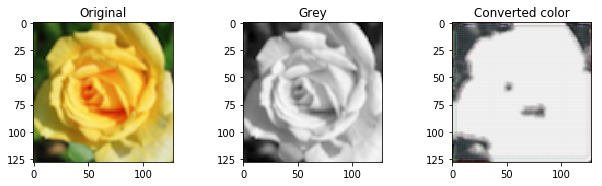

Epoch: 2
Train loss: 24.949133868445642
Test loss: 0.32328426622552797


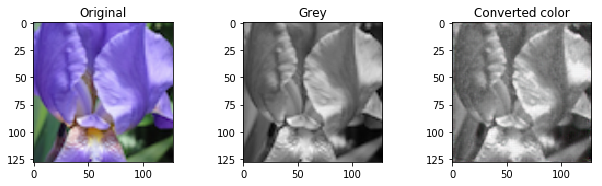

Epoch: 3
Train loss: 14.628584121732274
Test loss: 0.6184151089400984


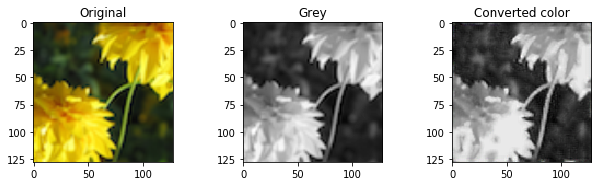

Epoch: 4
Train loss: 14.034445296041667
Test loss: 0.42145732056815177


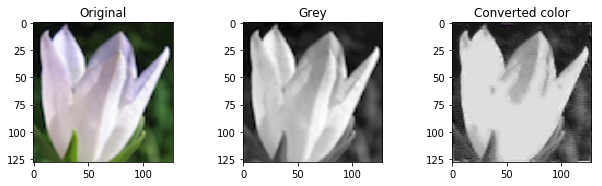

Epoch: 5
Train loss: 9.707788163141231
Test loss: 0.14153237555001397


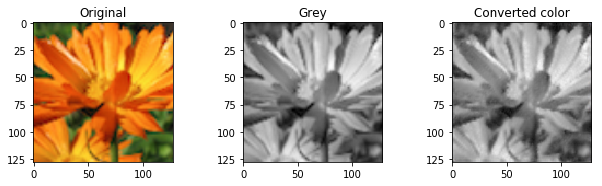

Epoch: 6
Train loss: 8.329437317865086
Test loss: 0.4108165260986425


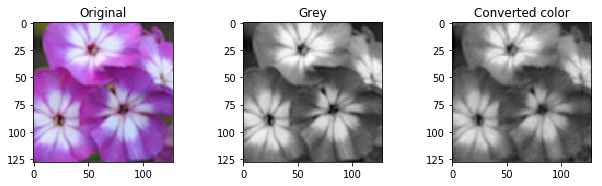

Epoch: 7
Train loss: 7.52689716736495
Test loss: 0.12135686866531614


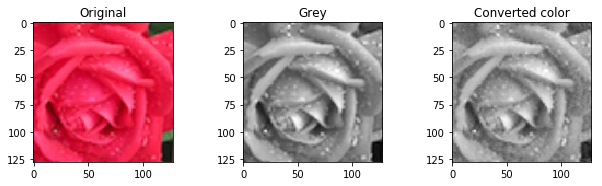

Epoch: 8
Train loss: 7.456610263529001
Test loss: 0.12706399307353422


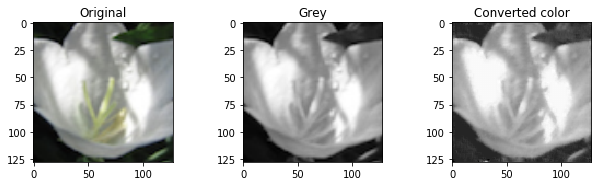

Epoch: 9
Train loss: 5.789136468883953
Test loss: 0.17469978614826687


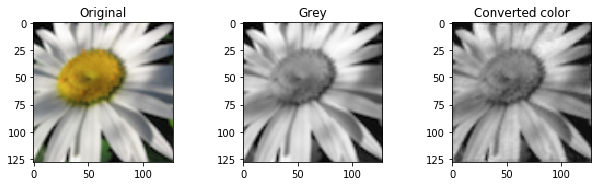

Epoch: 10
Train loss: 5.715401579145691
Test loss: 0.11132258173893206


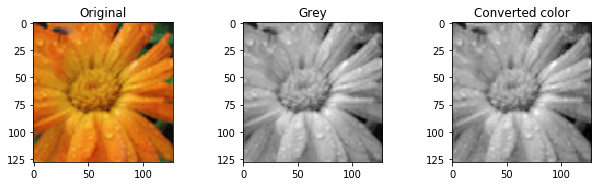

Epoch: 11
Train loss: 5.745646073643002
Test loss: 0.14929458910773974


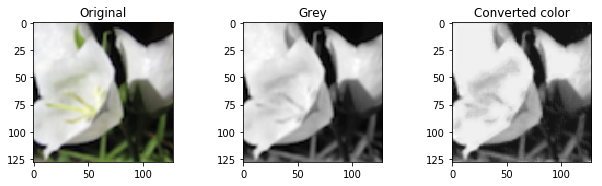

Epoch: 12
Train loss: 6.651762951805722
Test loss: 0.9705388224683702


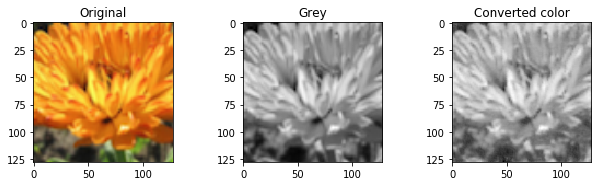

Epoch: 13
Train loss: 5.854629232220759
Test loss: 0.09058874560287222


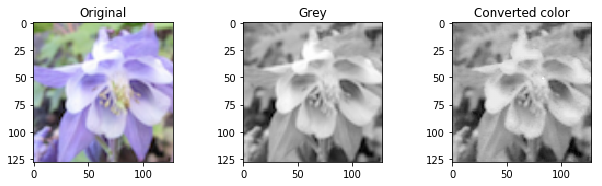

Epoch: 14
Train loss: 6.0186024444774375
Test loss: 0.0850228415656602


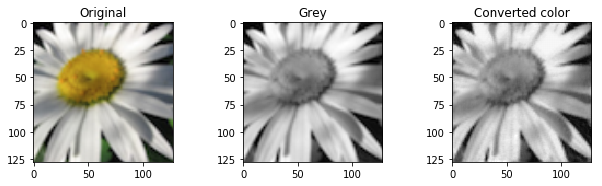

Epoch: 15
Train loss: 5.30729006054753
Test loss: 0.11441415430454072


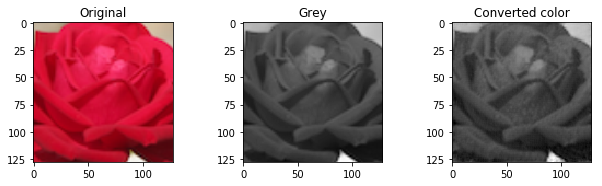

Epoch: 16
Train loss: 5.48409369084402
Test loss: 0.10820261236221995


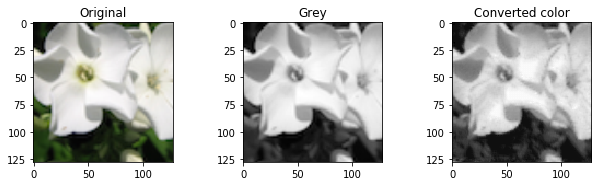

Epoch: 17
Train loss: 4.978029065736337
Test loss: 0.5404424449661747


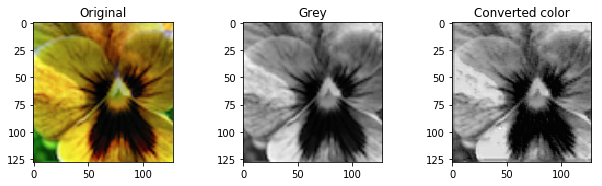

Epoch: 18
Train loss: 5.02506924449699
Test loss: 0.1328612098004669


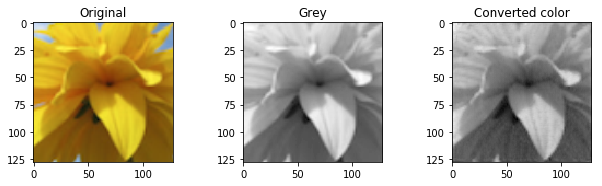

Epoch: 19
Train loss: 5.65318202303024
Test loss: 0.20846374070970342


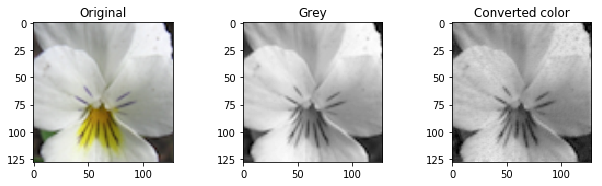

Epoch: 20
Train loss: 5.050717131663987
Test loss: 0.5350648793100845


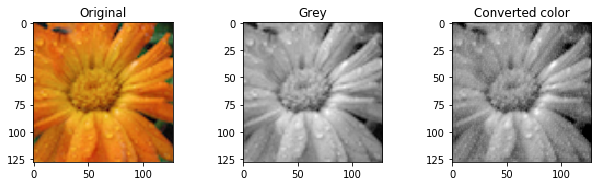

Epoch: 21
Train loss: 4.790678993194888
Test loss: 0.1842119704815559


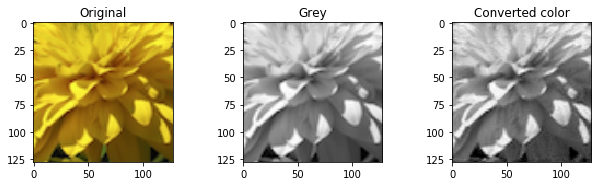

Epoch: 22
Train loss: 5.593303580215434
Test loss: 0.06759471595432842


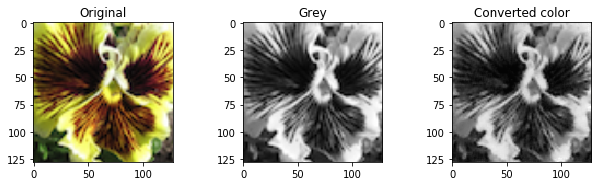

Epoch: 23
Train loss: 5.031851191626629
Test loss: 0.13905823876848444


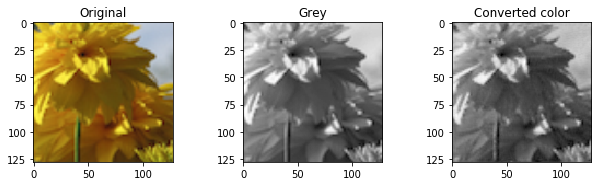

Epoch: 24
Train loss: 5.170503872548579
Test loss: 0.24222257122164592


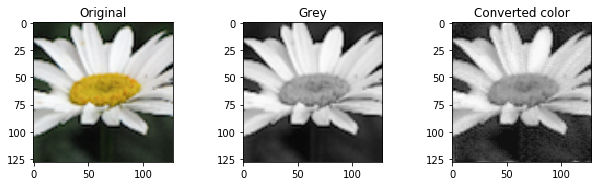

Epoch: 25
Train loss: 5.138465133321006
Test loss: 0.6141852789151017


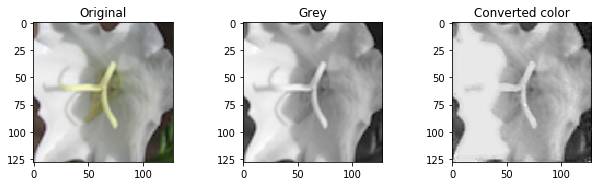

Epoch: 26
Train loss: 5.577891344029922
Test loss: 0.2781995791592635


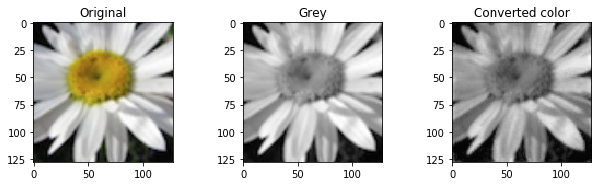

Epoch: 27
Train loss: 5.487269694975112
Test loss: 0.10217037005349994


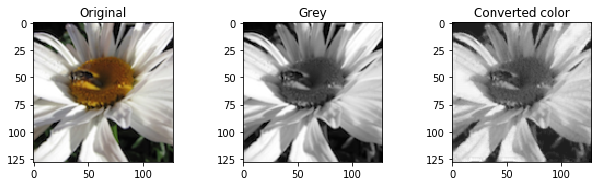

Epoch: 28
Train loss: 5.735322111620917
Test loss: 2.629276341293007


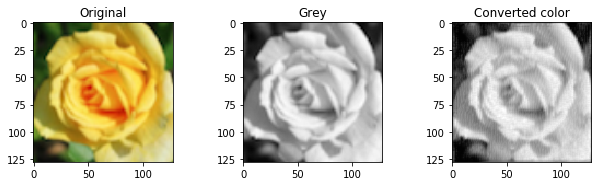

Epoch: 29
Train loss: 5.085863266373053
Test loss: 0.3363865412538871


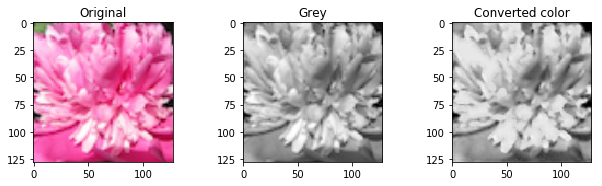

Epoch: 30
Train loss: 5.114816220731882
Test loss: 0.136353792695445


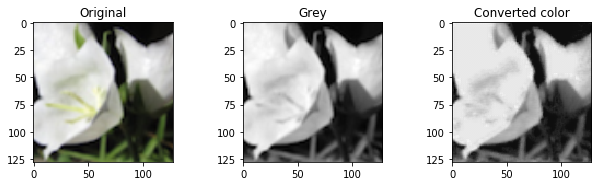

In [14]:
train_loss = []
valid_loss = []

# Training the model 

epochs = 30
#steps = 0


for e in range(epochs):
    running_loss = 0
    running_iter = 0
    for images,labels in trainloader:
        #images_gray = cv2.cvtColor(cv2.UMat(images), cv2.COLOR_BGR2GRAY)
        PILimage = transforms.ToPILImage()
        img = PILimage(images[0])
        images_gray = transforms.functional.to_grayscale(img, num_output_channels=3)
        
        image = Variable(images).to(device)
        tensor = transforms.ToTensor()
        image_gray = Variable(tensor(images_gray)).to(device)
        image_gray = image_gray.view(-1,3,128,128)
        #print(image.shape)
        #print(image_gray.shape)
        optimizer.zero_grad()
    
        output = autoencoder(image) 
        #print(output.shape)
        loss = criterion(output, image_gray)           # remove [1:] and test
        loss.backward()              # For gradient calcultion
        optimizer.step()             # Optimizng - Tuning the weights of the model
    
        running_iter +=1
        running_loss += loss.item()
    
    
    autoencoder.eval()
    test_loss = 0
    test_iter = 0
    
    with torch.no_grad():
        for images, labels in testloader:
            #images_gray = cv2.cvtColor(cv2.UMat(images), cv2.COLOR_BGR2GRAY)
            PILimage = transforms.ToPILImage()
            img = PILimage(images[0])
            images_gray = transforms.functional.to_grayscale(img, num_output_channels=3)
            tensor = transforms.ToTensor()        
            
            image = Variable(images).to(device)
            image_gray = Variable(tensor(images_gray)).to(device)
            img_gray = image_gray.view(-1,3,128,128)
            
            output = autoencoder(image)
            loss = criterion(output, img_gray)
        
            test_iter +=1
            test_loss += loss.item()
      
    
    # Let's visualize the first image of the last batch in our validation set
    orig = image[0].cpu()
    gray = image_gray[0].cpu()
    conv_gray = output[0].cpu()
    
    orig = orig.data.numpy()
    gray = gray.data.numpy()
    conv_gray = conv_gray.data.numpy()
    #print(orig.shape)
    #print(gray.shape)
    #print(conv_gray.shape)
    print("Epoch:",e+1)
    print('Train loss:',running_loss)
    print('Test loss:',test_loss)
    show_img(orig, gray, conv_gray)
    train_loss.append(running_loss / running_iter)
    valid_loss.append(test_loss / test_iter)
    test_loss = 0
    running_loss = 0
    autoencoder.train()

In [15]:
#file_path = '..input/color-flowers/checkpoint_autoencoder.pth'
torch.save(autoencoder.state_dict(), 'checkpoint_autoencoder_graytorgb.pth')

In [16]:
def show_test_img(orig, gray, conv_gray):
    #orig = np.transpose(orig, (1, 2, 0))
    #gray = np.transpose(gray, (1, 2, 0))
    #gray_img = transforms.ToPILImage()
    #gray = transforms.functional.to_grayscale(gray_img(np.uint8(orig)), num_output_channels=3)
    conv_gray = np.transpose(conv_gray, (1, 2, 0))
   

    fig=plt.figure(figsize=[10,5])
    
    #orig = orig.swapaxes(0, 1).swapaxes(1, 2)
    #gray = gray.swapaxes(0, 1).swapaxes(1, 2)
    #converted_gray = conv_gray.swapaxes(0, 1).swapaxes(1, 2)
    
    # Normalize for display purpose
    #orig     = (orig - orig.min()) / (orig.max() - orig.min())
    #gray    = (gray - gray.min()) / (gray.max() - gray.min())
    #denoised = (conv_gray - conv_gray.min()) / (conv_gray.max() - conv_gray.min())
    
    fig.add_subplot(1, 3, 1, title='Original')
    plt.imshow(orig)
    
    fig.add_subplot(1, 3, 2, title='Gray')
    plt.imshow(gray,cmap='gray')
    
    fig.add_subplot(1, 3, 3, title='Converted gray')
    plt.imshow(conv_gray)
    
    fig.subplots_adjust(wspace = 0.5)
    plt.show()

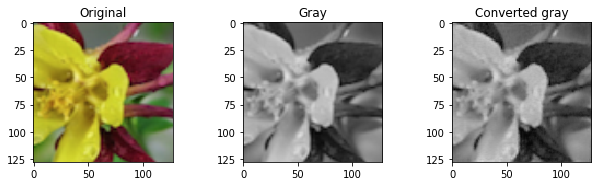

In [17]:
import random
import numpy
img, _ = random.choice(test_data)
c_img = img


tensor = transforms.ToPILImage()
c_img = tensor(c_img)
gray = transforms.functional.to_grayscale(c_img, num_output_channels=3)

image = img.resize_((1, 3, 128, 128))


image = Variable(image).cuda()
gray_img = autoencoder(image)


show_test_img(c_img,gray,gray_img[0].data.cpu().numpy())
#show_img(c_img[0].numpy(), gray[0].data.cpu().numpy(), gray_img[0].data.cpu().numpy())